# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split
import pNormSoftmax

# Evaluate logits

In [5]:
AUROC_min = lambda x,y: 1-metrics.AUROC(x,y)
SAC = 0.95
SAC_min = lambda x,y: torch.as_tensor(1-metrics.SAC(x,y,SAC))
d_aurc = {}
d_auroc = {}
d_baseline_aurc = {}
d_baseline_auroc = {}
d_baseline_sac = {}
d_sac = {}
acc = {}

In [6]:
DATASET = 'ImageNet'
VAL_SIZE = 0.1 #5000
for MODEL_ARC in models.list_models():
    print(MODEL_ARC)
    #if MODEL_ARC in df['model'].values:
    #    print('ja foi')
    #    continue
    if 'quantized' in MODEL_ARC:
        print('quantized - skip')
        continue
    with torch.no_grad():
        try: logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev)
        except: 
            print('cant find')
            continue
    logits_val,labels_val,logits_test,labels_test = split.split_logits(logits,labels,VAL_SIZE)
    risk_val = measures.wrong_class(logits_val,labels_val).float()
    risk_test = measures.wrong_class(logits_test,labels_test).float()
    acc[MODEL_ARC] = (1-risk_test.mean().item())
    p,beta = pNormSoftmax.optimize.p_and_beta(logits_val,risk_val,metrics.AURC)
    #T_nll = pNormSoftmax.optimize.T_fromloss(logits_val,labels_val,torch.nn.CrossEntropyLoss())
    d_baseline_aurc[MODEL_ARC] = metrics.AURC(risk_test,measures.MSP(logits_test))
    d_aurc[MODEL_ARC] = metrics.AURC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta))
    #d_aurc[MODEL_ARC] = metrics.AURC(risk_test,measures.MSP(logits_test.div(T_nll)))

    p,beta = pNormSoftmax.optimize.p_and_beta(logits_val,risk_val,AUROC_min)

    d_auroc[MODEL_ARC] = metrics.AUROC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta))
    d_baseline_auroc[MODEL_ARC] = metrics.AUROC(risk_test,measures.MSP(logits_test))
    #d_auroc[MODEL_ARC] = metrics.AUROC(risk_test,measures.MSP(logits_test.div(T_nll)))
    p,beta = pNormSoftmax.optimize.p_and_beta(logits_val,risk_val,AUROC_min)

    d_sac[MODEL_ARC] = metrics.SAC(risk_test,pNormSoftmax.pNormSoftmax(logits_test,p,beta),SAC)
    d_baseline_sac[MODEL_ARC] = metrics.SAC(risk_test,measures.MSP(logits_test),SAC)
    
    

alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
deeplabv3_mobilenet_v3_large
cant find
deeplabv3_resnet101
cant find
deeplabv3_resnet50
cant find
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
fasterrcnn_mobilenet_v3_large_320_fpn
cant find
fasterrcnn_mobilenet_v3_large_fpn
cant find
fasterrcnn_resnet50_fpn
cant find
fasterrcnn_resnet50_fpn_v2
cant find
fcn_resnet101
cant find
fcn_resnet50
cant find
fcos_resnet50_fpn
cant find
googlenet
inception_v3
keypointrcnn_resnet50_fpn
cant find
lraspp_mobilenet_v3_large
cant find
maskrcnn_resnet50_fpn
cant find
maskrcnn_resnet50_fpn_v2
cant find
maxvit_t
mc3_18
cant find
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mvit_v1_b
cant find
mvit_v2_s
cant find
quantized_googlenet
quantized - skip
quantiz

In [7]:
baseline_aurc = np.array(list(d_baseline_aurc.values()))
baseline_auroc = np.array(list(d_baseline_auroc.values()))
baseline_sac = np.array(list(d_baseline_sac.values()))
sac = np.array(list(d_sac.values()))
aurc = np.array(list(d_aurc.values()))
auroc = np.array(list(d_auroc.values()))
acc = np.array(list(acc.values()))

In [8]:
((auroc-baseline_auroc)).min()*100

-0.022569471255318163

In [9]:
((baseline_aurc-aurc)/baseline_aurc).max()*100

51.4444873923097

In [10]:
d_baseline_aurc['efficientnetv2_xl']

0.06975009669222765

In [11]:
d_aurc['efficientnetv2_xl']

0.03386751699327077

In [12]:
d_baseline_auroc['efficientnetv2_xl']

0.7732405309418356

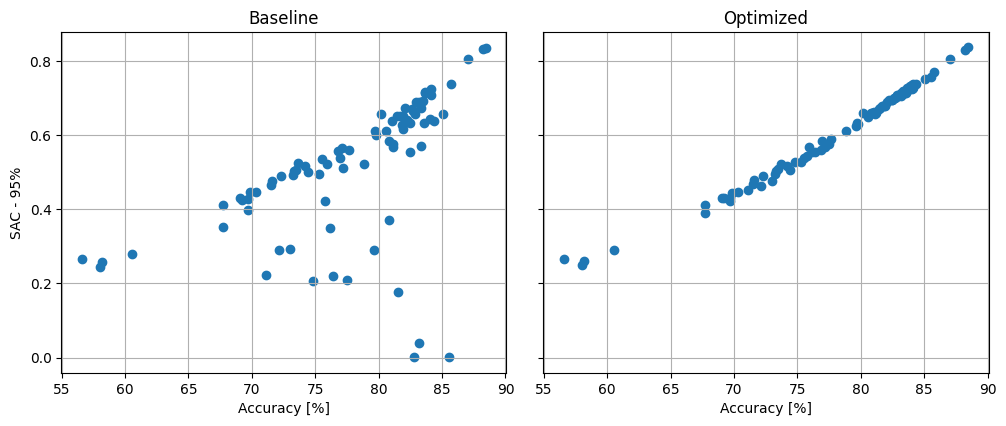

In [20]:
fig,axes = plt.subplots(1,2,figsize = (10,4), sharey=True)
fig.tight_layout()
axes[0].scatter(acc*100,baseline_sac)
axes[0].set_title('Baseline')
axes[0].set_ylabel('SAC - 95%')
axes[1].scatter(acc*100,sac)
axes[1].set_title('Optimized')

for ax in axes:
    ax.grid()
    ax.set_xlabel('Accuracy [%]')
plt.show()